In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import logging
import seaborn as sns
import numpy as np
import cmdstanpy
import json

from baynes.plotter import FitPlotter
from baynes.toyMC import SpectraSampler
from baynes.analysis import standard_analysis, multithreaded_run, dict_to_json
from baynes.probability import HoSpectrum, hdi, ptolemy, allowed_beta
from baynes.model_utils import get_model
from numba import njit, prange

from sympy import symbols, sin, diff, erf, exp, sqrt, Piecewise, And
from sympy.utilities.lambdify import lambdify
from scipy.special import gamma
from scipy.constants import elementary_charge, hbar, c, electron_mass
from scipy import integrate
from scipy.optimize import curve_fit

import math
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 15
plt.rcParams["legend.edgecolor"] = "white"

plt.rc('axes', axisbelow=True)

cmdstanpy.utils.get_logger().setLevel(logging.ERROR)
coeffs = np.loadtxt("parameters.dat")[:,1:]

from scipy.constants import hbar, c

m_nu = 0.5
me = 510998.95
mT = 931.49410242e6*3.01604928;
mhe3 = 931.49410242e6*3.0160293;
mhe = mhe3 - me + 24.6
Q = mT - mhe - me;
Krec = 3.44;
K0 = Q-Krec

Q_T = K0-0.2
A = 3.57e8

g_to_ev = 5.6095883571872E+32
output_dir = "/home/pietro/work/numass/ptolemy/slides/figures/"




@njit()
def ptolemy_cont(E, coeffs, m_nu, Q=18589.8):
    """Compute the b-decay spectrum of tritium in graphene."""
    E = np.asarray(E)
    N = len(E)
    y = np.zeros(N)
    me = 510998.95
    mhe3 = 931.49410242e6 * 3.0160293
    lambda_val = 4.21e-5
    eps0 = 5.76
    Gf = 1.1663787e-23
    Vud = 0.97373
    gsq = (Gf * Vud) ** 2 * (1 + (1.25 * 1.65) ** 2)
    NH3 = 1 / 1.66054e-24 / 3.01604928

    const_discrspe = NH3 * gsq * lambda_val**2 / (4 * np.pi**3 * 6.582119e-16)
    const_contspe = NH3 * gsq * lambda_val / (2 * np.pi ** (7.0 / 2.0) * 6.582119e-16)

    i_disc = lambda_val / (2 * np.pi**3)
    pb = np.sqrt(E**2 + 2 * E * me)


    for j in range(N):
        QKE = Q - E[j] - eps0
        if QKE >= m_nu:
            b = -pb[j] + np.sqrt(2 * mhe3 * (QKE - m_nu))
            bl = b * lambda_val
            pl = pb[j] * lambda_val
            expbl = np.exp(-(bl**2))
            exppl = np.exp(-(pl**2))
            erfplbl = math.erf(pl) + math.erf(bl)

            pb2_2mhe3 = pb[j] ** 2 / (2 * mhe3)
            kinf2 = np.sqrt(1 - (m_nu / (4.0 + QKE - pb2_2mhe3)) ** 2)

            I0 = (
                np.sqrt(np.pi)
                / (2 * lambda_val)
                * pb[j]
                * (QKE - pb2_2mhe3) ** 2
                * erfplbl
            )
            I1 = (
                1
                / (2 * lambda_val**2)
                * (QKE - pb2_2mhe3)
                * (QKE - 5.0 * pb2_2mhe3)
                * (exppl - expbl)
            )
            I2 = (
                1
                / (4 * lambda_val**3)
                * ((5.0 * pb2_2mhe3 - 3.0 * QKE) * pb[j] / mhe3)
                * (-2 * pl * exppl - 2 * bl * expbl + np.sqrt(np.pi) * erfplbl)
            )
            I3 = (
                1
                / (2 * lambda_val**4)
                * ((5.0 * pb2_2mhe3 - QKE) / mhe3)
                * (exppl * (1 + pl**2) - expbl * (1 + bl**2))
            )
            I4 = (
                5
                * pb[j]
                / (32 * mhe3**2 * lambda_val**5)
                * (
                    -expbl * (6 * bl + 4 * bl**3)
                    - exppl * (6.0 * pl + 4 * pl**3)
                    + 3 * np.sqrt(np.pi) * erfplbl
                )
            )
            I5 = (
                1
                / (8 * mhe3**2 * lambda_val**6)
                * (
                    exppl * (2 + 2 * pl**2 + pl**4)
                    - expbl * (2.0 + 2.0 * bl**2 + bl**4)
                )
            )
            y[j] += const_contspe * (E[j] + me) * kinf2 * (I0 + I1 + I2 + I3 + I4 + I5)

    return y

@njit()
def ptolemy_disc(E, coeffs, m_nu, Q=18589.8, k=0):
    """Compute the b-decay spectrum of tritium in graphene."""
    E = np.asarray(E)
    N = len(E)
    y = np.zeros(N)
    me = 510998.95
    mhe3 = 931.49410242e6 * 3.0160293
    lambda_val = 4.21e-5
    eps0 = 5.76
    Gf = 1.1663787e-23
    Vud = 0.97373
    gsq = (Gf * Vud) ** 2 * (1 + (1.25 * 1.65) ** 2)
    NH3 = 1 / 1.66054e-24 / 3.01604928

    const_discrspe = NH3 * gsq * lambda_val**2 / (4 * np.pi**3 * 6.582119e-16)
    const_contspe = NH3 * gsq * lambda_val / (2 * np.pi ** (7.0 / 2.0) * 6.582119e-16)

    i_disc = lambda_val / (2 * np.pi**3)
    pb = np.sqrt(E**2 + 2 * E * me)

    Qn = Q - coeffs[k][0]
    pn = coeffs[k][1]
    an = coeffs[k][2]
    bn = coeffs[k][3]
    cn = coeffs[k][4]
    for j in range(N):
        E_nu = Qn - E[j]
        if E_nu >= m_nu:
            xb = (pb[j] - pn) / pn
            y[j] += (
                const_discrspe
                * pb[j]
                * (E[j] + me)
                * np.sqrt(E_nu**2 - m_nu**2)
                * E_nu
                * (an + xb * lambda_val * pn * (2 * bn - lambda_val * pn * cn))
            )

    return y

In [3]:
def save(title):
    plt.savefig(output_dir + title + ".pdf", bbox_inches="tight")


def power_fit(x, alpha, beta):
    return beta*np.power(x, alpha)

def load_file(json_file):
    with open(json_file) as f:
        data = json.load(f)
    return data

def get_los_his(data, prob):
    los, his = [], []
    for key, posteriors in data.items():
        post = []
        for p in posteriors:
            if np.mean(p)<2:
                post.extend(p)
        lo, hi = hdi(post, prob=prob)
        los.append(lo)
        his.append(hi)
    return los, his



@njit(parallel=False)
def ptolemyint(E, coeffs, m_nu, Q=18589.8):
    """Compute the b-decay spectrum of tritium in graphene."""
    y = 0
    me = 510998.95
    mhe3 = 931.49410242e6*3.0160293
    lambda_val = 4.21e-5
    eps0 = 5.76
    Gf = 1.1663787e-23
    Vud = 0.97373
    gsq = (Gf*Vud)**2 * (1+(1.25*1.65)**2)
    NH3=1/1.66054e-24/3.01604928

    const_discrspe=NH3*gsq*lambda_val**2/(4 * np.pi**3 * 6.582119e-16)
    const_contspe=NH3*gsq*lambda_val/(2 * np.pi**(7./2.) * 6.582119e-16)


    i_disc = lambda_val / (2 * np.pi**3)
    pb = np.sqrt(E**2 + 2 * E * me)

    for k in range(64):
        Qn = Q - coeffs[k][0]
        pn = coeffs[k][1]
        an = coeffs[k][2]
        bn = coeffs[k][3]
        cn = coeffs[k][4]
        E_nu = Qn - E
        if E_nu >= m_nu:
            xb = (pb - pn) / pn
            y += (
                const_discrspe
                * pb
                * (E + me)
                * np.sqrt(E_nu**2 - m_nu**2)
                * E_nu
                * (an + xb * lambda_val * pn * (2 * bn - lambda_val * pn * cn))
            )

    i_cont = 1 / (np.pi ** (7. / 2.))
    QKE = Q - E - eps0
    if QKE >= m_nu:
        b = -pb + np.sqrt(2 * mhe3 * (QKE - m_nu))
        bl = b * lambda_val
        pl = pb * lambda_val
        expbl = np.exp(-(bl**2))
        exppl = np.exp(-(pl**2))
        erfplbl = math.erf(pl) + math.erf(bl)
        pb2_2mhe3 = pb ** 2 / (2 * mhe3)
        kinf2 = np.sqrt(1 - (m_nu / (4.0 + QKE - pb2_2mhe3)) ** 2)
        I0 = (
            np.sqrt(np.pi)
            / (2 * lambda_val)
            * pb
            * (QKE - pb2_2mhe3) ** 2
            * erfplbl
        )
        I1 = (
            1
            / (2 * lambda_val**2)
            * (QKE - pb2_2mhe3)
            * (QKE - 5.0 * pb2_2mhe3)
            * (exppl - expbl)
        )
        I2 = (
            1
            / (4 * lambda_val**3)
            * ((5.0 * pb2_2mhe3 - 3.0 * QKE) * pb / mhe3)
            * (-2 * pl * exppl - 2 * bl * expbl + np.sqrt(np.pi) * erfplbl)
        )
        I3 = (
            1
            / (2 * lambda_val**4)
            * ((5.0 * pb2_2mhe3 - QKE) / mhe3)
            * (exppl * (1 + pl**2) - expbl * (1 + bl**2))
        )
        I4 = (
            5
            * pb
            / (32 * mhe3**2 * lambda_val**5)
            * (
                -expbl * (6 * bl + 4 * bl**3)
                - exppl * (6.0 * pl + 4 * pl**3)
                + 3 * np.sqrt(np.pi) * erfplbl
            )
        )
        I5 = (
            1
            / (8 * mhe3**2 * lambda_val**6)
            * (
                exppl * (2 + 2 * pl**2 + pl**4)
                - expbl * (2.0 + 2.0 * bl**2 + bl**4)
            )
        )
        y += const_contspe * (E + me) * kinf2 * (I0 + I1 + I2 + I3 + I4 + I5)

    #norm = lambda_val * gsq / (2*mhe3)

    return y



def allowed_betasy():
    E = symbols("E")
    m_nu, Q = symbols("m_nu, Q")
    me = 510998.95
    p = sqrt(E**2+2*E*me)
    alpha = 1/137
    beta = p/(E+me)
    eta = 2*np.pi*alpha/beta
    F = eta * (1.002037 - 0.001427 * beta)/(1-exp(-eta))
    return Piecewise((F*p*(E+me)*(Q-E)*sqrt((Q - E) ** 2 - m_nu**2), And(Q-E>=m_nu, m_nu>=0, Q>=0)),(0, True))+1e-8

def ptolemysym(coeffs):
    """Compute the b-decay spectrum of tritium in graphene."""
    E = symbols("E")
    y = symbols("y")
    m_nu, Q = symbols("m_nu, Q")
    me = 510998.95
    mhe3 = 2809413505.67592
    lambda_val = 4.21e-5
    eps0 = 5.76

    i_disc = lambda_val / (2 * np.pi**3)
    pb = sqrt(E**2 + 2 * E * me)

    y = 0
    for k in range(64):
        Qn = Q - coeffs[k][0]
        pn = coeffs[k][1]
        an = coeffs[k][2]
        bn = coeffs[k][3]
        cn = coeffs[k][4]
        E_nu = Qn - E
        xb = (pb - pn) / pn
        y += Piecewise((i_disc * pb * (E + me) * sqrt(E_nu**2 -m_nu**2) * E_nu * (an + xb * lambda_val * pn * (2 * bn - lambda_val * pn * cn)), E_nu>=m_nu), (0, True))

    i_cont = 1 / (np.pi**(7 / 2))
    QKE = Q - E - eps0
    b = -pb + sqrt(2 * mhe3 * (QKE - m_nu))
    bl = b * lambda_val
    pl = pb * lambda_val
    expbl = exp(-bl**2)
    exppl = exp(-pl**2)
    erfplbl = erf(pl) + erf(bl)
    pb2_2mhe3 = pb**2 / (2 * mhe3)
    kinf2 = sqrt(1 - (m_nu / (4.0 + QKE - pb2_2mhe3))**2)
    I0 = sqrt(np.pi) / (2 * lambda_val) * pb * (QKE - pb2_2mhe3)**2 * erfplbl
    I1 = 1 / (2 * lambda_val**2) * (QKE - pb2_2mhe3) * (QKE - 5.0 * pb2_2mhe3) * (exppl - expbl)
    I2 = 1 / (4 * lambda_val**3) * ((5.0 * pb2_2mhe3  - 3.0 * QKE)* pb / mhe3) * (
            -2 * pl * exppl - 2 * bl * expbl + sqrt(np.pi) * erfplbl)
    I3 = 1 / (2 * lambda_val**4) * ((5.0 * pb2_2mhe3 - QKE )/ mhe3) * (
            exppl * (1 + pl**2) - expbl * (1 + bl**2))
    I4 = 5 * pb / (32 * mhe3**2 * lambda_val**5) * (
            -expbl * (6 * bl + 4 * bl**3) - exppl * (6.0 * pl + 4 * pl**3) + 3 * sqrt(np.pi) * erfplbl)
    I5 = 1 / (8 * mhe3**2 * lambda_val**6) * (exppl * (2 + 2 * pl**2 + pl**4) - expbl * (2.0 + 2.0 * bl**2 + bl**4))
    y += Piecewise((i_cont * (E + me) * kinf2 * (I0 + I1 + I2 + I3 + I4 + I5), QKE>=m_nu), (0, True))

    return y

m_nus = symbols("m_nu")
Es = symbols("E")
Qs = symbols("Q")

partial_m_pt = diff(ptolemysym(coeffs), m_nus)
dens_pt = 1/ptolemysym(coeffs) * (partial_m_pt**2)
f_pt = lambdify((Es, m_nus, Qs), dens_pt, "numpy")

partial_Q_pt = diff(ptolemysym(coeffs), Qs)
dens_pt_Q = 1/ptolemysym(coeffs) * (partial_Q_pt**2)
f_pt_Q = lambdify((Es, m_nus, Qs), dens_pt_Q, "numpy")

partial_m_beta = diff(allowed_betasy(), m_nus)
dens_beta = 1/allowed_betasy() * (partial_m_beta**2)
f_beta = lambdify((Es, m_nus, Qs), dens_beta, "numpy")

(-21.0, 5.0)

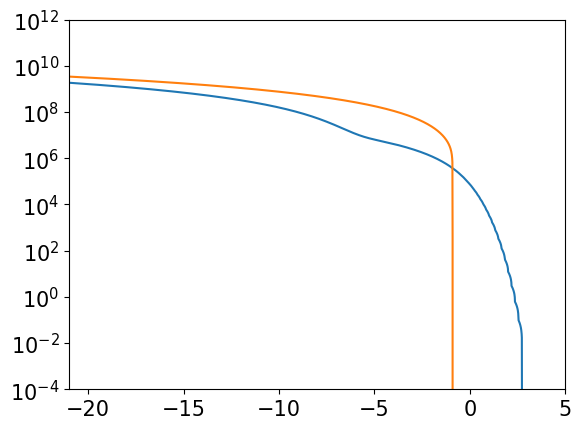

In [4]:
dE = 0.01
m_nu=0.7
E = np.arange(Q-27, Q+5, dE)
y = ptolemy(E, coeffs, m_nu, Q)*1e-3*24*3600*365
y_cont = ptolemy_cont(E, coeffs, m_nu, Q)*1e-3*24*3600*365

yt = allowed_beta(E, m_nu, Q_T)*1e-3*24*3600*365/1.2686803301886793


plt.plot(E-K0, y)

plt.plot(E-K0, yt)
plt.yscale("log")
plt.ylim(1e-4, 1e12)
plt.xlim(-21, 5)



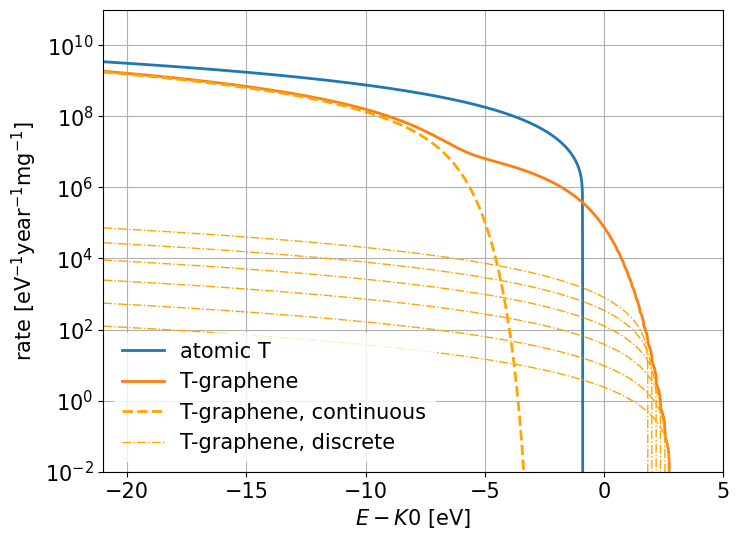

In [50]:
f = plt.figure(figsize=(8, 6))
plt.plot(E-K0, yt, label="atomic T", lw=2)
plt.plot(E-K0, y, label="T-graphene", lw=2)
plt.plot(E-K0, y_cont, label="T-graphene, continuous", c="orange", ls="--", lw=2)

for k in range(6):
    y_disc = ptolemy_disc(E, coeffs, m_nu, Q, k)*1e-3*24*3600*365
    if k == 0:
        plt.plot(E-K0, y_disc, label="T-graphene, discrete", c="orange", ls="-.", lw=1)
    else:
        plt.plot(E-K0, y_disc, c="orange", ls="-.", lw=1)



plt.yscale("log")
plt.ylim(1e-2, 1e11)
plt.xlim(-21, 5)
plt.grid(True, which="both")
plt.legend()
plt.ylabel("rate [eV$^{-1}$year$^{-1}$mg$^{-1}$]")
plt.xlabel("$E-K0$ [eV]")
save("spectrum")

2652752


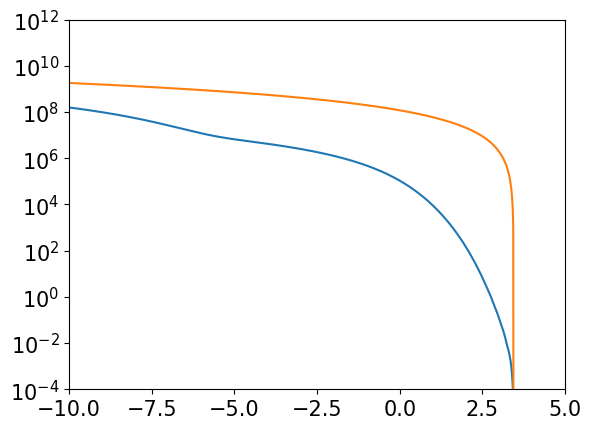

In [4]:
m_nu = 0
dE = 0.01
E = np.arange(Q-20, Q+5, dE)
y = ptolemy(E, coeffs, m_nu, Q)*1e-3*24*3600*365
plt.plot(E-K0, y)

yt = allowed_beta(E, m_nu, Q)*1e-3*24*3600*365
plt.plot(E-K0, yt)
plt.yscale("log")
plt.ylim(1e-4, 1e12)
plt.xlim(-10, 5)

normM20  = int(np.sum(y)*1e-3*dE)
normT5 = int(np.sum(yt)*1e-3*dE)
E = np.arange(Q-10, Q+5, dE)
y = ptolemy(E, coeffs, m_nu, Q)*1e-3*24*3600*365
yt = allowed_beta(E, m_nu, Q)*1e-3*24*3600*365
normT10 = int(np.sum(yt)*1e-3*dE)

normM10  = int(np.sum(y)*1e-3*dE)

normT10_corr = int(normT10/1.2686803301886793)
normT5_corr = int(normT5/1.2686803301886793)

print(normT10_corr)


In [14]:
normT10_corr

2642819

In [ ]:
2652411

In [122]:
2048856/3

682952.0

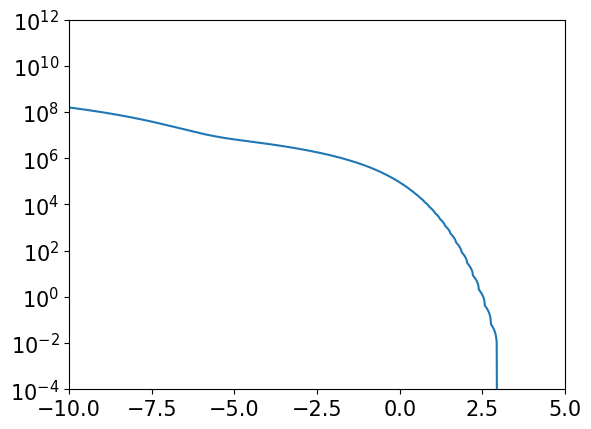

In [6]:
dE = 0.01
E = np.arange(Q-20, Q+5, dE)
y = ptolemy(E, coeffs, m_nu, Q)*1e-3*24*3600*365
plt.plot(E-K0, y)

plt.yscale("log")
plt.ylim(1e-4, 1e12)
plt.xlim(-10, 5)

normM20  = int(np.sum(y)*1e-3*dE)
E = np.arange(Q-10, Q+5, dE)
y = ptolemy(E, coeffs, m_nu, Q)*1e-3*24*3600*365

normM10  = int(np.sum(y)*1e-3*dE)



## Sensitivity function

<lambdifygenerated-4>:2: RuntimeWarning: invalid value encountered in sqrt
  return (select([less_equal(m_nu, -E + Q),True], [-0.000686321310042043*m_nu*(1077.18092666151 - 7.61199993338816*sqrt(9.78475591779592e-7*E**2 + E))*(-E + Q)*(E + 510998.95)*sqrt(9.78475591779592e-7*E**2 + E)/sqrt(-m_nu**2 + (-E + Q)**2),0], default=nan) + select([less_equal(m_nu, -E + Q - 0.187089018191407),True], [-0.000686321310042043*m_nu*(4641.82423528311 - 32.7582039226147*sqrt(9.78475591779592e-7*E**2 + E))*(E + 510998.95)*sqrt(9.78475591779592e-7*E**2 + E)*(-E + Q - 0.187089018191407)/sqrt(-m_nu**2 + (-E + Q - 0.187089018191407)**2),0], default=nan) + select([less_equal(m_nu, -E + Q - 0.371208495956932),True], [-0.000686321310042043*m_nu*(19925.2254339711 - 140.392620690961*sqrt(9.78475591779592e-7*E**2 + E))*(E + 510998.95)*sqrt(9.78475591779592e-7*E**2 + E)*(-E + Q - 0.371208495956932)/sqrt(-m_nu**2 + (-E + Q - 0.371208495956932)**2),0], default=nan) + select([less_equal(m_nu, -E + Q - 0.552358433296

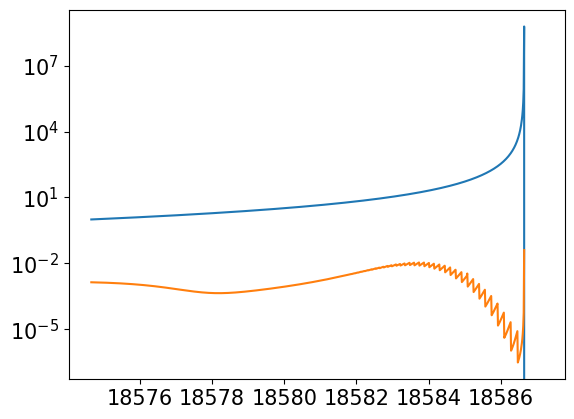

In [188]:
m_nu = 0.0001
E = np.linspace(Q-12, Q+0.5, 1000)

pt_norm = f_pt(18000,m_nu, Q)
beta_norm = f_beta(18000,m_nu, Q)

sp1 = ptolemy(E, coeffs, m_nu, Q)
beta = allowed_beta(E, m_nu, Q)
beta_d = np.array([f_beta(e,m_nu, Q) for e in E])/f_beta(Q-12,m_nu, Q)
pt_d = np.array([f_pt(e, m_nu, Q) for e in E])/f_pt(Q-12, m_nu, Q)

#for m in [0, 0.05, 0.1, 0.5, 1, 2]:
 #   plt.plot(E, ptolemy(E, coeffs, m, Q))
#plt.plot(E, beta/sum(beta))
#plt.plot(E, sp1/sum(sp1))
plt.plot(E, beta_d)
plt.plot(E, pt_d*beta_norm/pt_norm)
plt.yscale("log")


<lambdifygenerated-4>:2: RuntimeWarning: invalid value encountered in sqrt
  return (select([less_equal(m_nu, -E + Q),True], [-0.000686321310042043*m_nu*(1077.18092666151 - 7.61199993338816*sqrt(9.78475591779592e-7*E**2 + E))*(-E + Q)*(E + 510998.95)*sqrt(9.78475591779592e-7*E**2 + E)/sqrt(-m_nu**2 + (-E + Q)**2),0], default=nan) + select([less_equal(m_nu, -E + Q - 0.187089018191407),True], [-0.000686321310042043*m_nu*(4641.82423528311 - 32.7582039226147*sqrt(9.78475591779592e-7*E**2 + E))*(E + 510998.95)*sqrt(9.78475591779592e-7*E**2 + E)*(-E + Q - 0.187089018191407)/sqrt(-m_nu**2 + (-E + Q - 0.187089018191407)**2),0], default=nan) + select([less_equal(m_nu, -E + Q - 0.371208495956932),True], [-0.000686321310042043*m_nu*(19925.2254339711 - 140.392620690961*sqrt(9.78475591779592e-7*E**2 + E))*(E + 510998.95)*sqrt(9.78475591779592e-7*E**2 + E)*(-E + Q - 0.371208495956932)/sqrt(-m_nu**2 + (-E + Q - 0.371208495956932)**2),0], default=nan) + select([less_equal(m_nu, -E + Q - 0.552358433296

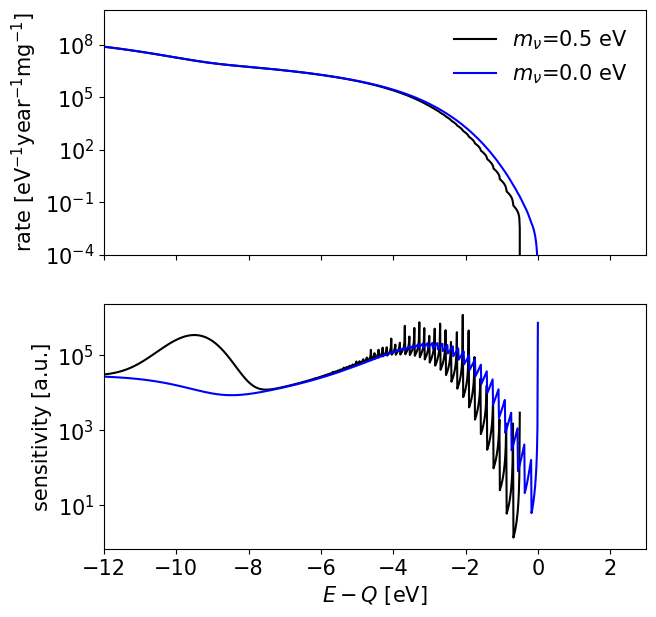

In [191]:
output_dir = "/home/pietro/work/phd/numass/ptolemy/slides/figures/"
def save(title):
    plt.savefig(output_dir + title + ".pdf", bbox_inches="tight")



f = plt.figure("ptolemy_sensitivity", figsize=(7,7))
ax = f.subplots(2, 1, sharex=True)
colors = ["black", "blue"]
for i, m in enumerate([0.5, 0.00001]):
    spectrum = ptolemy(E, coeffs, m, Q)
    sens = np.array([f_pt(e, m, Q) for e in E])/f_pt(16000, m, Q)

    ax[0].plot(E[:]-Q, spectrum*1e-3*24*3600*365, label=f"$m_\\nu$={round(m, 1)} eV", c=colors[i])
    ax[1].plot(E[:]-Q, sens, c=colors[i])


plt.xlim(-12, 3)
ax[0].set_ylim(1e-4, 1e10)

ax[1].set_yscale("log")
ax[0].set_yscale("log")
ax[1].set_xlabel("$E-Q$ [eV]")
ax[1].set_ylabel("sensitivity [a.u.]")
ax[0].set_ylabel("rate [eV$^{-1}$year$^{-1}$mg$^{-1}$]")

ax[0].legend()
save("sens")

### Plot the posteriors for $m_\nu$ and combine their samples in a histogram. The upper limit on the parameter's estimate is given by the confidence interval of this distribution.

In [83]:
p=FitPlotter(output_dir=output_dir)
data_array_1 = load_file("data/msweep1_v3.json")
data_array = load_file("data/msweep100_v2.json")

In [8]:
def save(title):
    plt.savefig(output_dir + title + ".pdf", bbox_inches="tight")

def  robust_posterior(posteriors, x_max=0.55, title="T-graphene"):
  full = posteriors.flatten()
  ax = p.new_figure('multi').subplots()

  prob = 0.68
  print( str(prob*100) + '% highest density interval: ', hdi(full, prob=prob))
  ax.axvspan(hdi(full, prob=prob)[1], x_max, color='gray', alpha=0.2, lw=0)

  prob = 0.9
  print( str(prob*100) + '% highest density interval: ', hdi(full, prob=prob))
  ax.axvspan(hdi(full, prob=prob)[1], x_max, color='gray', alpha=0.2, lw=0)

  sns.histplot(posteriors.transpose(), bins=100, alpha=1, multiple='stack', legend=False, lw=0., palette='flare', ax=ax)
  ax.set_title(r"$m_\nu$=0 eV, 1 $\mu$g "+title)
  ax.grid(False)
  ax.set_xlim(0, x_max)
  ax.set_xlabel('$m_{fit}$ [eV]', fontsize=14), 1, 10, 100
  ax.set_ylabel('counts', fontsize=14)
  ax.figure.set_size_inches(8, 4)

robust_posterior(np.array(data_array_1["0.0001"]))
#save("robust_TG_m0")

KeyError: '0.0001'

68.0% highest density interval:  [3.58087001e-06 4.10297596e-02]
90.0% highest density interval:  [1.43867631e-07 6.51437953e-02]


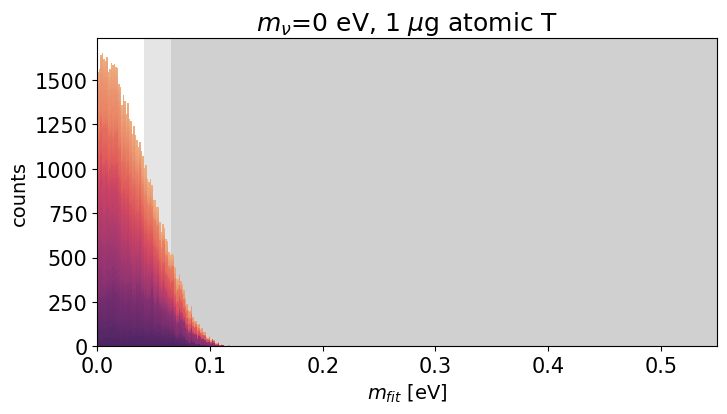

In [39]:
data_array_1_beta = load_file("beta/m0.json")
data_array_1 = load_file("beta/m0_v2.json")
robust_posterior(np.array(data_array_1["1"]), title="atomic T")
save("robust_T_m0")


In [78]:
data_array_1.keys()

dict_keys(['1e-05', '0.01', '0.02', '0.05', '0.07', '0.1', '0.15'])

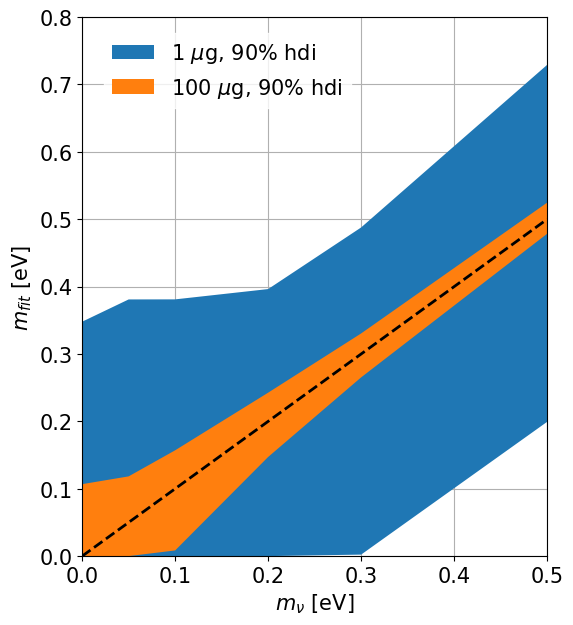

In [84]:
los_1, his_1 = get_los_his(data_array_1, 0.9)
los, his =get_los_his(data_array, 0.9)

fp = FitPlotter(col_wrap=4)


ms = [float(d) for d in data_array.keys()]
f, ax = plt.subplots(figsize=(6,7))
ax.fill_between(ms, los_1, his_1, label="1 $\mu$g, 90% hdi")
ax.fill_between(ms, los, his, label="100 $\mu$g, 90% hdi")
plt.plot([0, 0.5], [0, 0.5], color="black", ls="--", lw=2)
ax.set_xlim(0.0, 0.5)
ax.set_ylim(0, 0.8)
ax.set_xlabel(r"$m_\nu$ [eV]")
ax.set_ylabel(r"$m_{fit}$ [eV]")
ax.legend(bbox_to_anchor=(0.6,0.99), edgecolor="white")
ax.grid()
save("mass_sweep")

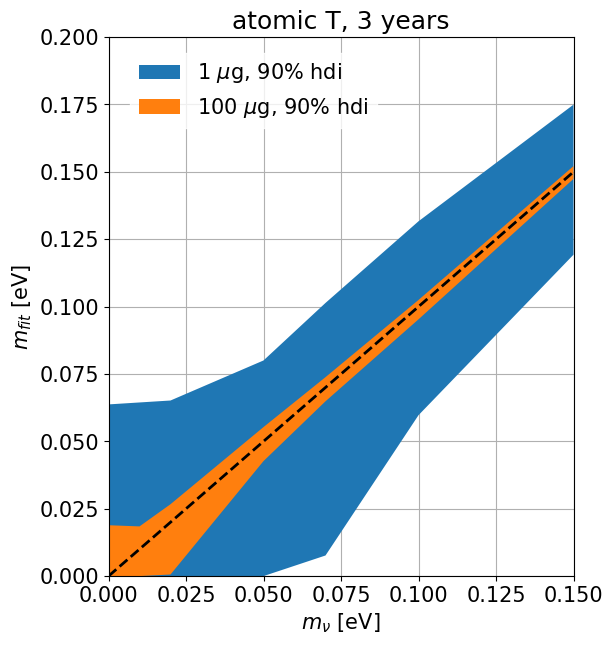

In [81]:
data_array_1 = load_file("beta/msweep1.json")
data_array_1.pop("0.01")
data_array = load_file("beta/msweep100.json")

los_1, his_1 = get_los_his(data_array_1, 0.9)
los, his =get_los_his(data_array, 0.9)

fp = FitPlotter(col_wrap=4)


ms = [float(d) for d in data_array.keys()]
ms_1 = [float(d) for d in data_array_1.keys()]

f, ax = plt.subplots(figsize=(6,7))
ax.fill_between(ms_1, los_1, his_1, label="1 $\mu$g, 90% hdi")
ax.fill_between(ms, los, his, label="100 $\mu$g, 90% hdi")
plt.plot([0, 0.5], [0, 0.5], color="black", ls="--", lw=2)
ax.set_xlim(0.0, 0.15)
ax.set_ylim(0, 0.2)
ax.set_xlabel(r"$m_\nu$ [eV]")
ax.set_ylabel(r"$m_{fit}$ [eV]")
ax.legend(bbox_to_anchor=(0.6,0.99), edgecolor="white")
ax.grid()
ax.set_title("atomic T, 3 years")
save("mass_sweep_beta")
#plt.xscale("log")

In [44]:
datan = load_file("ptolemy/m0.json")
#datan[str(1*normM10*3/36600)] = data_array_1["0.0001"]
#datan[str(100*normM10*3/36600)] = data_array["0.0001"]



ns = np.array([float(k) for k in datan.keys()])*36600

data = OrderedDict(sorted(datan.items()))

In [48]:
from collections import OrderedDict

from matplotlib import cm
colors = cm.viridis(np.linspace(0,1,10))[7:]

In [45]:
datan = load_file("ptolemy/m0.json")

#data_1 = load_file("data/msweep1_v3.json")["0.0001"]
data_100 = load_file("data/msweep100_v2.json")["0.0001"]



ns = np.array([float(k) for k in datan.keys()])*42000
ks = list(datan.keys())

items = []
items.append((normM10*3, data_1))
items.append((normM10*300, data_100))

for i, n in enumerate(ns):
    items.append((n, datan[ks[i]]))
items.sort()
dataor = OrderedDict(items)

NameError: name 'data_1' is not defined

In [46]:
list(data_100.keys())

AttributeError: 'list' object has no attribute 'keys'

[-0.20972147  3.40987014]
[-0.21187358  2.26393301]
[-0.21486707  1.63751095]


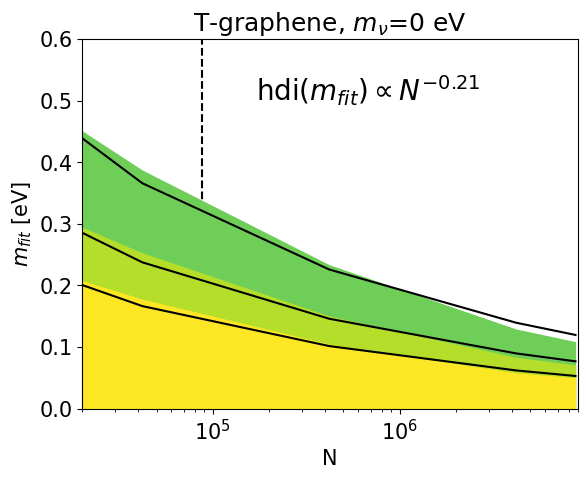

In [25]:
ns = list(dataor.keys())



for i, prob in enumerate([0.9, 0.68, 0.5]):
    los, his = get_los_his(dataor, prob)

    pars, errs = curve_fit(power_fit, ns, his)
    print(pars)
    plt.fill_between(ns, 0, his, alpha=1, label = f"{prob*100}%", color=colors[i])
   # plt.text(ns[0]+400, his[0]-0.11, f"{prob*100}%")
    plt.plot(ns, power_fit(ns, pars[0], pars[1]), color="black")
    #plt.plot(ns, his)
plt.xlim(ns[0], ns[-1])
#plt.axvline(normT10_corr*3, alpha=1, c="black")
plt.ylim(0, 0.6)
plt.xlim(2e4, 9e6)
plt.title(r"T-graphene, $m_\nu$=0 eV")
plt.xscale("log")
plt.xlabel("N")
plt.ylabel(r"$m_{fit}$ [eV]")
plt.axvline(normM10*3, c="black", zorder=0, label="1 $\mu$g", ls="--")
#plt.legend(edgecolor="w")
plt.text(ns[2]-250000, 0.5,  r"hdi$(m_{fit})\propto N^{-0.21}$", fontsize=20)
save("N_TG")

dict_keys(['0.001', '0.01', '0.1', '1', '10', '100'])
[-0.29369841  7.42285121]
[-0.27965748  3.94726134]
[-0.2777237   2.62676056]


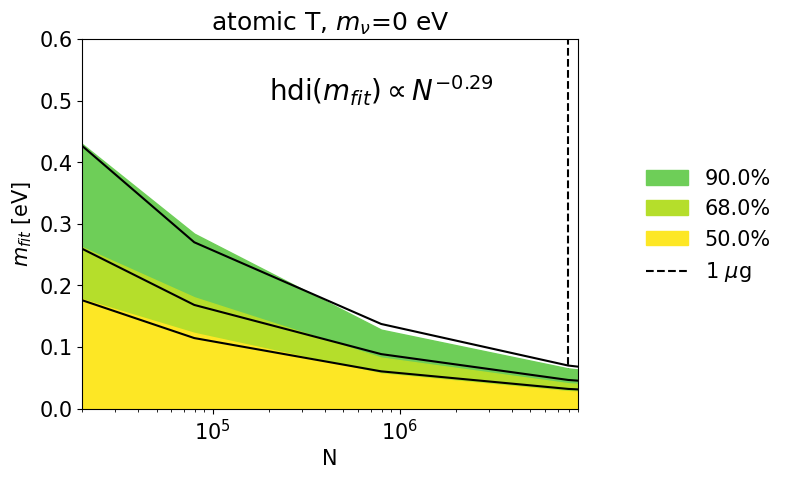

In [55]:
data_T = load_file("beta/m0_v2.json")
print(data_T.keys())
ns = np.array([float(k) for k in data_T.keys()])*normT10_corr*3
n_max=5

for i, prob in enumerate([0.9, 0.68, 0.5]):
    los, his = get_los_his(data_T, prob)

    pars, errs = curve_fit(power_fit, ns[:n_max], his[:n_max])
    print(pars)
    plt.fill_between(ns[:n_max], 0, his[:n_max], alpha=1, label = f"{prob*100}%", color=colors[i])
   # plt.text(ns[0]+400, his[0]-0.11, f"{prob*100}%")
    plt.plot(ns[:n_max], power_fit(ns[:n_max], pars[0], pars[1]), color="black")
    #plt.plot(ns, his)
plt.xlim(ns[0], ns[-1])
#plt.axvline(normT10_corr*3, alpha=1, c="black")
plt.ylim(0, 0.6)
plt.xlim(2e4, 9e6)
plt.title(r"atomic T, $m_\nu$=0 eV")
plt.xscale("log")
plt.xlabel("N")
plt.ylabel(r"$m_{fit}$ [eV]")
plt.axvline(normT10_corr*3, c="black", zorder=0, label="1 $\mu$g", ls="--")
plt.legend(edgecolor="w", bbox_to_anchor=(1.1, 0.7))
plt.text(2e5, 0.5, r"hdi$(m_{fit})\propto N^{-0.29}$", fontsize=20)
save("N_T")

In [45]:
normT10_corr*3

2048856

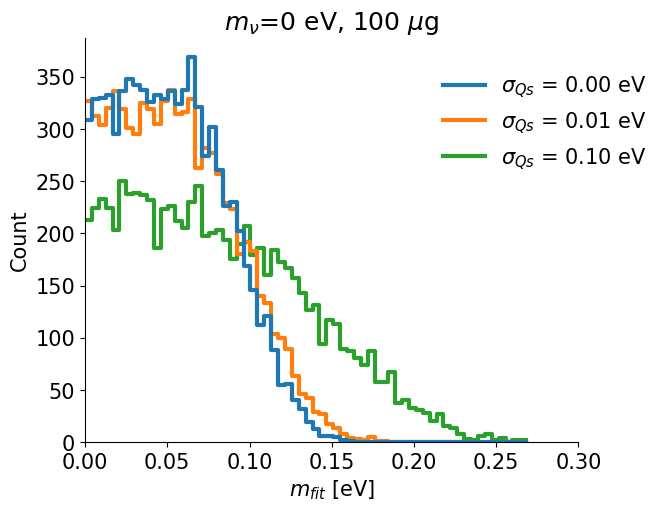

In [56]:
fp = FitPlotter(col_wrap=4, output_dir=output_dir, save=False, output_format=".pdf")

fit_noQ = cmdstanpy.from_csv("data/allQ/noQs_300_005/posterior")
fit_001 = cmdstanpy.from_csv("data/allQ/300_001_m005/posterior")
fit_01 = cmdstanpy.from_csv("data/allQ/300_01_m005/posterior")
fp.add_fit(fit_01, fit_title="$\sigma_{Qs}$ = 0.10 eV")
fp.add_fit(fit_001, fit_title="$\sigma_{Qs}$ = 0.01 eV")
fp.add_fit(fit_noQ, fit_title="$\sigma_{Qs}$ = 0.00 eV")

fp.dis_plot(fit_titles="all", parameters=r"m_nu", legend=True, kind="hist", alpha=1, element="step", fill=False, lw=3)
ax = fp.get_current_figure().axes[0]
ax.set_xlim(0,0.3)
ax.set_title(r"$m_\nu$=0 eV, 100 $\mu$g")
ax.set_xlabel("$m_{fit}$ [eV]")
fp.update_legend(bbox_to_anchor=(1.1,0.9))

In [57]:
fp.save_figures("all")

In [52]:
fp.cat_plot(fit_titles="all", parameters="m_nu", legend=False)
fp.add_lines([0.05], zorder=0, ls="--", color="black")


KeyboardInterrupt: 

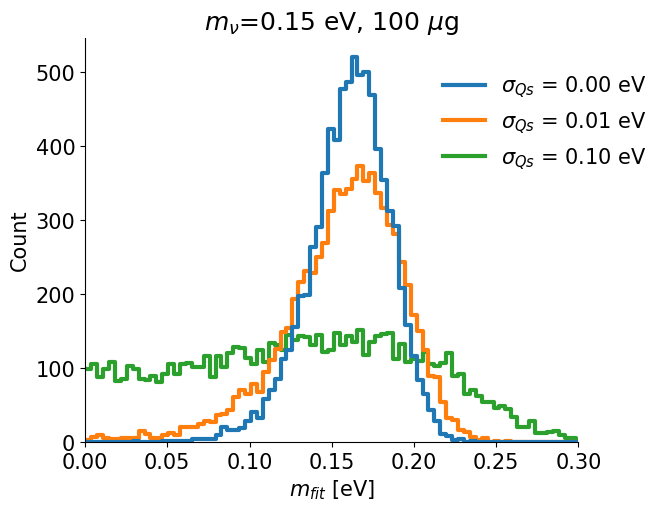

In [58]:
fp.fits={}
fit_noQ = cmdstanpy.from_csv("data/allQ/noQs_300_02/posterior")
fit_001 = cmdstanpy.from_csv("data/allQ/300_001_m02/posterior")
fit_01 = cmdstanpy.from_csv("data/allQ/300_01_m02/posterior")
fp.add_fit(fit_01, fit_title="$\sigma_{Qs}$ = 0.10 eV")
fp.add_fit(fit_001, fit_title="$\sigma_{Qs}$ = 0.01 eV")
fp.add_fit(fit_noQ, fit_title="$\sigma_{Qs}$ = 0.00 eV")

fp.dis_plot(fit_titles="all", parameters=r"m_nu", legend=True, kind="hist", alpha=1, element="step", fill=False, lw=3)
ax = fp.get_current_figure().axes[0]
ax.set_xlim(0,0.3)
ax.set_title(r"$m_\nu$=0.15 eV, 100 $\mu$g")
ax.set_xlabel("$m_{fit}$ [eV]")

fp.update_legend(bbox_to_anchor=(1.1,0.9))

In [37]:
fp.save_figures("all")

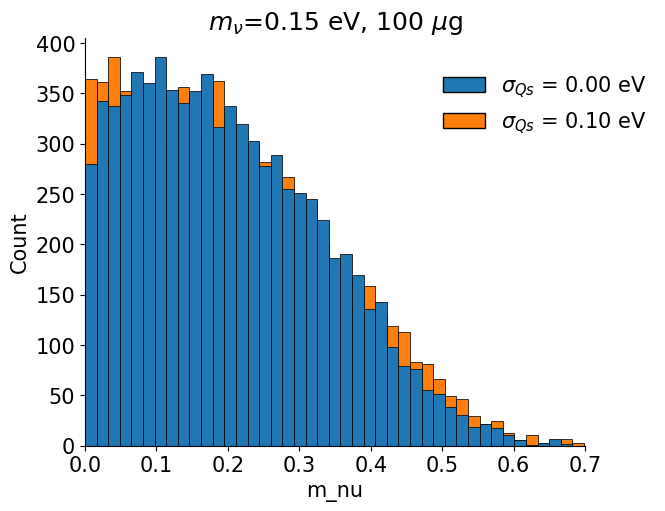

In [57]:
fp.fits={}
fit_noQ = cmdstanpy.from_csv("data/allQ/noQs_1_005/posterior")
fit_01 = cmdstanpy.from_csv("data/allQ/1_01_005/posterior")
fp.add_fit(fit_01, fit_title="$\sigma_{Qs}$ = 0.10 eV")
fp.add_fit(fit_noQ, fit_title="$\sigma_{Qs}$ = 0.00 eV")

fp.dis_plot(fit_titles="all", parameters="m_nu", legend=True, kind="hist", alpha=1)
ax = fp.get_current_figure().axes[0]
ax.set_xlim(0,0.7)
ax.set_title(r"$m_\nu$=0.15 eV, 100 $\mu$g")
fp.update_legend(bbox_to_anchor=(1.1,0.9))

In [5]:
m = 0.2
A = 3.57e8
A_T = A * 1
bkg = 0
FWHM= 0.1
s_Q = 0.1
n_events  = normM10 * 3


s = SpectraSampler({'T-graphene': [ptolemy, [coeffs, 0.5, Q], A_T]}, flat_bkg=bkg, FWHM=FWHM, dE=0.02, integrate=False, ROI=[Q-10, Q+0.5], n_events=n_events)


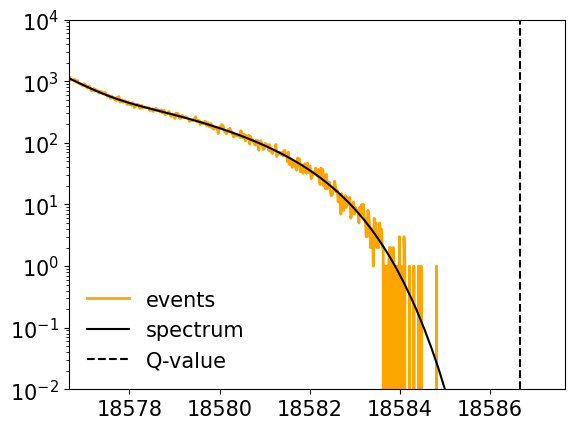

In [41]:
events = s.sample()[0]
f, ax = plt.subplots()
ax.plot(s.ROI_bin_centers, events, color="orange", label="events", lw=2)
ax.plot(s.ROI_bin_centers, s.binned_pdf*s.n_events, label="spectrum", c="black")
ax.set_ylim(1e-2, 1e4)
ax.set_xlim(Q-10, Q+1)
ax.axvline(Q, ls="--", c="black", label="Q-value")
ax.set_yscale("log")
ax.legend()
save("events")

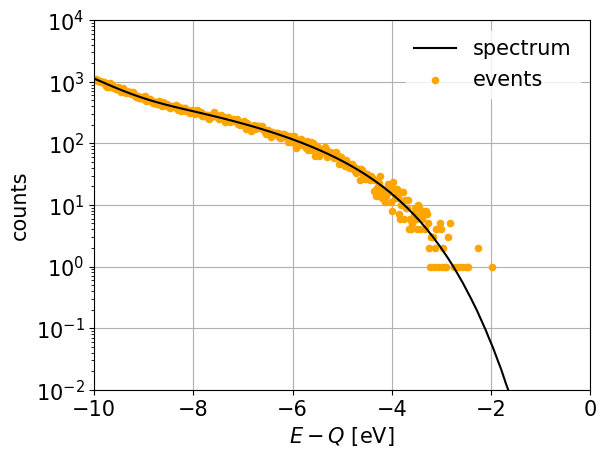

In [16]:
events = s.sample()[0]

f, ax = plt.subplots()
ax.plot(s.ROI_bin_centers - Q, s.binned_pdf*s.n_events, label="spectrum", c="black")
#ax.axvline(0, ls="--", c="black", label="Q-value")
ax.scatter(s.ROI_bin_centers - Q, events, color="orange", label="events", s=20)
ax.set_yscale("log")
ax.set_ylim(1e-2, 1e4)
ax.set_xlim(-10, 0)
ax.set_xlabel("$E-Q$ [eV]")
ax.set_ylabel("counts")
ax.legend()

ax.grid()
save("events")